# **Loading Data**

In [23]:
import yfinance as yf
import pandas as pd

ticker = "AAPL"  # Apple stock
data = yf.download(ticker, start="2018-01-01", end="2023-12-31")
data.head()


/tmp/ipython-input-1643994981.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2018-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.380993,40.390372,39.677736,39.888715,102223600
2018-01-03,40.373970,40.917824,40.310679,40.444296,118071600
2018-01-04,40.561501,40.664645,40.338803,40.446634,89738400
2018-01-05,41.023312,41.110045,40.566195,40.657619,94640000
2018-01-08,40.870926,41.166292,40.772467,40.870926,82271200


# **Setting Up A Simple Moving Average**

*What it means when SMA50 crosses above SMA200*

SMA50 = average price over the last 50 trading days → reflects short-term trend.

SMA200 = average price over the last 200 trading days → reflects long-term trend.

When SMA50 crosses above SMA200, it means:

The short-term trend is now stronger than the long-term trend.

Prices in the recent ~10 weeks have been moving up faster than the long-term ~9-month average.

Traders often see this as a bullish signal — sometimes called a "Golden Cross".

Interpretation: Momentum is shifting upward, so it may be a good time to buy.

When SMA50 crosses below SMA200

The short-term trend has weakened compared to the long-term trend.

Recent prices are dropping relative to the long-term average.

Traders call this a "Death Cross" — often a bearish signal.

Interpretation: Momentum is shifting downward, so it may be a good time to sell or avoid buying.

*Why use crossovers at all?*

The idea is to avoid getting caught in small market noise and instead catch big trend changes.
It’s a lagging indicator — meaning it reacts after prices have already moved — but it helps reduce false alarms compared to very short-term indicators.



---



In [24]:
data['SMA50'] = data['Close'].rolling(window=50).mean()
data['SMA200'] = data['Close'].rolling(window=200).mean()


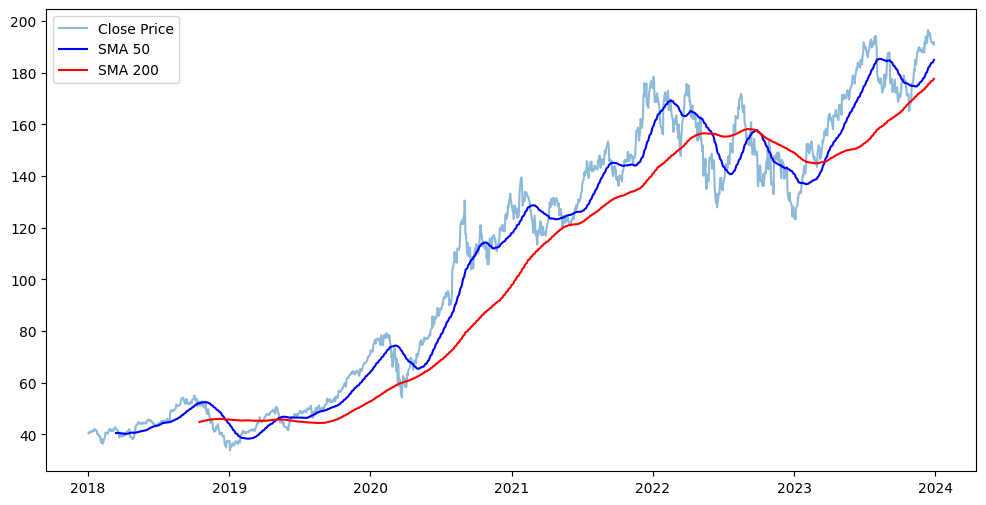

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close Price', alpha=0.5)
plt.plot(data['SMA50'], label='SMA 50', color='blue')
plt.plot(data['SMA200'], label='SMA 200', color='red')
plt.legend()
plt.show()


In [26]:
import numpy as np

data['Signal'] = 0
data['Signal'][50:] = np.where(data['SMA50'][50:] > data['SMA200'][50:], 1, 0)
data['Position'] = data['Signal'].diff()



/tmp/ipython-input-2513064621.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][50:] = np.where(data['SMA50'][50:] > data['SMA200'][50:], 1, 0)


# **Signal Strategy**

Step-by-step

Signal is set earlier to 1 when SMA50 > SMA200 (bullish) and 0 when SMA50 ≤ SMA200 (bearish or neutral).

.diff() calculates the difference between the current row’s signal and the previous row’s signal.

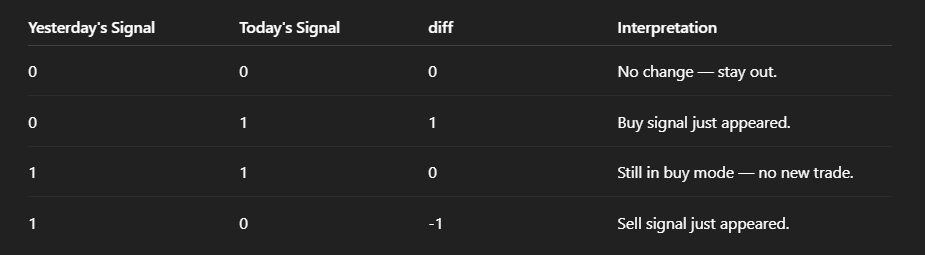


Why do this?

We don’t want to buy every day that SMA50 > SMA200 — just on the day it crosses above.Likewise, we don’t want to sell every day SMA50 < SMA200 — just on the day it crosses below.

So,

Position = 1 → Today is a buy entry day.

Position = -1 → Today is a sell exit day.

Position = 0 → No action today.





---



# **Backtesting Strategy**

Imagine this:

*You’ve just invented a magic coin-flip strategy:*

If heads → buy Apple stock.

If tails → sell Apple stock.

Before you go risk your rent money on it, you want to know:
"If I had been using this coin-flip strategy in the past, would I be richer or poorer today?"

That’s backtesting — it’s like time-travel for your trading idea.
You take:

Historical market data (old price charts).

Your rules (buy here, sell there).

Pretend you were trading back then.

See how much money you’d end up with.

In our SMA crossover example

We start with $10,000 (pretend money).

Every time the SMA50 crosses above SMA200 → we pretend we buy as many shares as possible.

Every time the SMA50 crosses below SMA200 → we pretend we sell all our shares and hold cash.

We keep doing this through all the historical data.

At the end, we check:

How much money do we have now?

Was it better than just holding the stock?

How often did we win vs. lose?

How big were the gains/losses?

*Why it’s important*

Without backtesting, you’re just guessing whether a strategy works.

Backtesting does not guarantee future profits (markets change), but it does tell you if your idea was a total disaster in the past.

It’s like checking old exam papers before taking a test — not perfect, but better than going in blind.



---



In [28]:
initial_capital = 10000.0
cash = initial_capital
shares = 0
trades = []

for i in range(len(data)):
    if data['Position'].iloc[i] == 1:  # BUY signal
        shares = cash / data['Close'].iloc[i]
        cash = 0
        trades.append(('BUY', data.index[i], data['Close'].iloc[i]))
    elif data['Position'].iloc[i] == -1:  # SELL signal
        cash = shares * data['Close'].iloc[i]
        shares = 0
        trades.append(('SELL', data.index[i], data['Close'].iloc[i]))

# Final portfolio value
final_value = cash + shares * data['Close'].iloc[-1]
final_value = float(final_value)


/tmp/ipython-input-2678996801.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_value = float(final_value)


# **Performance Metrics**

*The Problem It Solves*

Imagine two friends:

Ali made 10% last year.

Hamza made 12% last year.

At first glance, Hamza seems better.But… what if Hamza’s returns bounced wildly up and down every week, while Ali’s were steady and calm?Who’s actually the better trader?

The Sharpe Ratio answers exactly that —It tells you how much reward you’re getting per unit of risk you take.

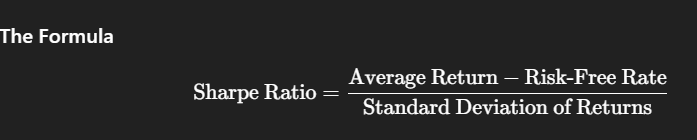

Breaking it Down

Average Return →
This is the mean return you made over the period.
If every month you made +1%, your average is 1%.

Risk-Free Rate →
This is the return you could have made without taking any risk, like putting your money in a government treasury bill.
If risk-free rate = 2% yearly, you subtract that from your average return to see how much extra you earned for taking risk.

Standard Deviation of Returns →
This measures how "bumpy" your returns are.
Higher standard deviation = more volatility (risk).

Interpretation:

Higher Sharpe = better risk-adjusted returns.

Sharpe ≈ 1 → Decent.

Sharpe ≈ 2 → Good.

Sharpe ≈ 3+ → Excellent.

Super Simple Analogy

Think of the Sharpe Ratio like a car’s fuel efficiency:

"Miles driven" = the returns you made.

"Liters of fuel used" = the risk you took.

Sharpe Ratio is basically miles per liter — how much return you get for each unit of risk.

A trader with high returns but huge volatility is like a sports car that’s super fast but burns fuel like crazy — fun, but dangerous for your wallet.
A high Sharpe Ratio trader is like a car that goes fast and sips fuel — efficient and sustainable.

In [29]:
stotal_return = (final_value / initial_capital - 1) * 100

# Daily returns
data['Daily Return'] = data['Close'].pct_change()
sharpe_ratio = (data['Daily Return'].mean() / data['Daily Return'].std()) * np.sqrt(252)

# Win rate calculation
wins = 0
losses = 0
for i in range(1, len(trades), 2):  # every buy-sell pair
    if i < len(trades):
        buy_price = trades[i-1][2]
        sell_price = trades[i][2]
        if sell_price > buy_price:
            wins += 1
        else:
            losses += 1
win_rate = (wins / (wins + losses) * 100) if (wins + losses) > 0 else 0


# **Print Results**

In [30]:
# =====================
# 6. PRINT RESULTS
# =====================
print(f"Initial Capital: ${initial_capital:,.2f}")
print(f"Final Value: ${final_value:,.2f}")
print(f"Total Return: {total_return:.2f}%")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Initial Capital: $10,000.00
Final Value: $10,000.00
Total Return: 0.00%
Win Rate: 0.00%
Sharpe Ratio: 0.98


# **Plot Results**

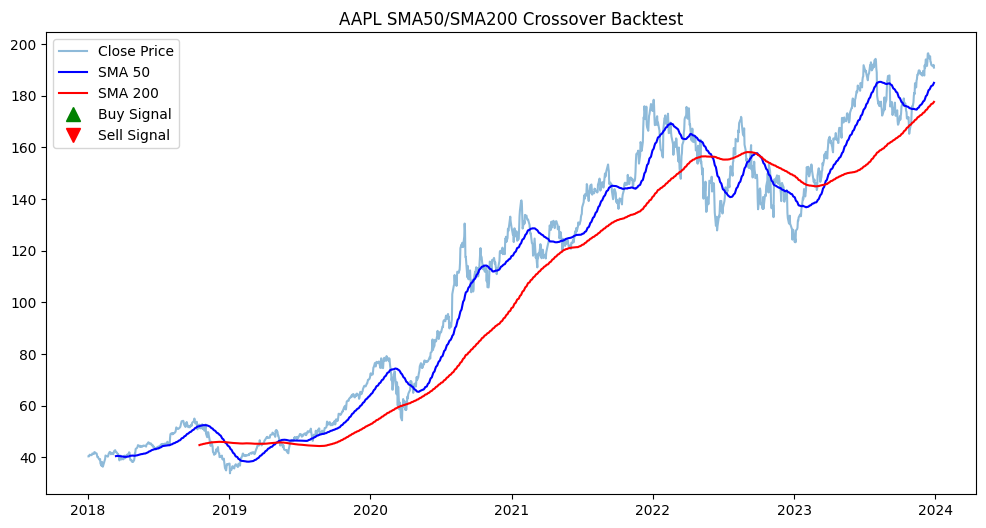

In [31]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close Price', alpha=0.5)
plt.plot(data['SMA50'], label='SMA 50', color='blue')
plt.plot(data['SMA200'], label='SMA 200', color='red')

# Buy signals
plt.plot(data[data['Position'] == 1].index,
         data['SMA50'][data['Position'] == 1],
         '^', markersize=10, color='green', label='Buy Signal')

# Sell signals
plt.plot(data[data['Position'] == -1].index,
         data['SMA50'][data['Position'] == -1],
         'v', markersize=10, color='red', label='Sell Signal')

plt.legend()
plt.title(f"{ticker} SMA50/SMA200 Crossover Backtest")
plt.show()